<a href="https://colab.research.google.com/github/horyekhunley/kdb_ai_projects/blob/main/multimodal_rag_kdb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kdbai_client

In [ ]:
import requests
import os
from PIL import Image
import io

In [ ]:
### This downloads image and text data

!mkdir -p ./data/images
!mkdir -p ./data/text

def get_github_repo_contents(repo_owner, repo_name, branch, folder_path):
    # Construct the API URL
    api_url = f"https://api.github.com/repos/{repo_owner}/{repo_name}/contents/{folder_path}?ref={branch}"

    # Send the request and process the response
    contents = requests.get(api_url).json()

    # Create the local directory if it doesn't exist
    fPath = f"./data/{folder_path.split('/')[-1]}"

    for item in contents:
        # Recursively list contents of subfolder
        if item['type'] == 'dir':
            get_github_repo_contents(repo_owner, repo_name, branch, f"{folder_path}/{item['name']}")
        # Download and save file
        elif item['type'] == 'file':
            file_url = f"https://raw.githubusercontent.com/{repo_owner}/{repo_name}/{branch}/{folder_path}/{item['name']}"
            print(file_url)
            r = requests.get(file_url, timeout=4.0)
            r.raise_for_status()  # Raises an exception for HTTP errors
            file_path = f"{fPath}/{item['name']}"

            if item['name'].lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                # Save image file
                with Image.open(io.BytesIO(r.content)) as im:
                    im.save(file_path)
            else:
                # Save text file
                with open(file_path, 'wb') as f:
                    f.write(r.content)

# Get the data
get_github_repo_contents(
    repo_owner='KxSystems',
    repo_name='kdbai-samples',
    branch='main',
    folder_path='multimodal_RAG_ImageBind/data'
)

https://raw.githubusercontent.com/KxSystems/kdbai-samples/main/multimodal_RAG_ImageBind/data/images/bat1.jpg
https://raw.githubusercontent.com/KxSystems/kdbai-samples/main/multimodal_RAG_ImageBind/data/images/bat2.jpg
https://raw.githubusercontent.com/KxSystems/kdbai-samples/main/multimodal_RAG_ImageBind/data/images/bear1.jpg
https://raw.githubusercontent.com/KxSystems/kdbai-samples/main/multimodal_RAG_ImageBind/data/images/bear2.jpg
https://raw.githubusercontent.com/KxSystems/kdbai-samples/main/multimodal_RAG_ImageBind/data/images/caterpillar1.jpg
https://raw.githubusercontent.com/KxSystems/kdbai-samples/main/multimodal_RAG_ImageBind/data/images/caterpillar2.jpg
https://raw.githubusercontent.com/KxSystems/kdbai-samples/main/multimodal_RAG_ImageBind/data/images/deer1.jpg
https://raw.githubusercontent.com/KxSystems/kdbai-samples/main/multimodal_RAG_ImageBind/data/images/deer2.jpg
https://raw.githubusercontent.com/KxSystems/kdbai-samples/main/multimodal_RAG_ImageBind/data/images/fox1.jpg

In [ ]:
!git clone https://github.com/facebookresearch/ImageBind

Cloning into 'ImageBind'...
remote: Enumerating objects: 117, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 117 (delta 48), reused 35 (delta 35), pack-reused 47
Receiving objects: 100% (117/117), 2.64 MiB | 24.13 MiB/s, done.
Resolving deltas: 100% (53/53), done.


In [ ]:
### Move to the ImageBind directory
os.chdir('./ImageBind')

In [ ]:
!pip install .

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import os
import PIL
from PIL import Image
import torch
from imagebind import data
from imagebind.models import imagebind_model
from imagebind.models.imagebind_model import ModalityType

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

# Instantiate model
model = imagebind_model.imagebind_huge(pretrained=True)
model.eval()
model.to(device)

  0%|          | 0.00/4.47G [00:00<?, ?B/s]

ImageBindModel(
  (modality_preprocessors): ModuleDict(
    (vision): RGBDTPreprocessor(
      (cls_token): tensor((1, 1, 1280), requires_grad=True)
      
      (rgbt_stem): PatchEmbedGeneric(
        (proj): Sequential(
          (0): PadIm2Video()
          (1): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
        )
      )
      (pos_embedding_helper): SpatioTemporalPosEmbeddingHelper(
        (pos_embed): tensor((1, 257, 1280), requires_grad=True)
        
      )
    )
    (text): TextPreprocessor(
      (pos_embed): tensor((1, 77, 1024), requires_grad=True)
      (mask): tensor((77, 77), requires_grad=False)
      
      (token_embedding): Embedding(49408, 1024)
    )
    (audio): AudioPreprocessor(
      (cls_token): tensor((1, 1, 768), requires_grad=True)
      
      (rgbt_stem): PatchEmbedGeneric(
        (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10), bias=False)
        (norm_layer): LayerNorm((768,), eps=1e-05, elementwise_affine=

In [ ]:
# Helper function to read the text from a file
def read_text_from_file(filename):
    try:
        # Open the file in read mode ('r')
        with open(filename, 'r') as file:
            # Read the contents of the file into a string
            text = file.read()
            file.close()
        return text
    except IOError as e:
        # Handle any I/O errors
        print(f"An error occurred: {e}")
        return None


#Helper functions to create embeddings
def getEmbeddingVector(inputs):
    with torch.no_grad():
        embedding = model(inputs)
    for key, value in embedding.items():
        vec = value.reshape(-1)
        vec = vec.numpy()
        return(vec)

def dataToEmbedding(dataIn,dtype):
    if dtype == 'image':
        data_path = [dataIn]
        inputs = {
        ModalityType.VISION: data.load_and_transform_vision_data(data_path, device)
        }
    elif dtype == 'text':
        txt = [dataIn]
        inputs = {
        ModalityType.TEXT: data.load_and_transform_text(txt, device)
        }
    vec = getEmbeddingVector(inputs)
    return(vec)

# Helper function to create a query vector from a natural language query
def queryToEmbedding(text):
    text = [text]
    inputs = {
        ModalityType.TEXT: data.load_and_transform_text(text, device)
    }
    vec = getEmbeddingVector(inputs)
    return(vec)

2. Data processing

In [ ]:
columns = ['path', 'media_type', 'embeddings']
df = pd.DataFrame(columns=columns)

In [ ]:
images = os.listdir('/content/data/images')
texts = os.listdir('/content/data/text')

embedding texts and images

In [ ]:
#loop through images, append a row in the dataframe containing each image's path, media_type (image), and embeddings
for image in images:
    path = "../data/images/" + image
    media_type = "image"
    embedding = dataToEmbedding(path,media_type)
    new_row = {'path': path,
               'media_type':media_type,
               'embeddings':embedding}
    df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

In [ ]:
df.shape

(12, 3)

In [ ]:
df.head()

,path,media_type,embeddings
0,../data/images/caterpillar1.jpg,image,"[0.033966806, 0.016641296, 0.024822084, -0.018..."
1,../data/images/bat2.jpg,image,"[-0.015404081, 0.006553277, -0.005401999, 0.01..."
2,../data/images/bat1.jpg,image,"[-0.006592049, 0.027778821, -0.022019383, -0.0..."
3,../data/images/deer1.jpg,image,"[0.0075792605, 0.0073336903, 0.04133869, 0.013..."
4,../data/images/hedgehog2.jpg,image,"[0.011653225, 0.013159762, -0.018287295, 0.003..."


In [ ]:
#loop through texts, append a row in the dataframe containing each text's path, media_type (text), and embeddings
for text in texts:
    path = "../data/text/" + text
    media_type = "text"
    txt_file = read_text_from_file(path)
    #print(txt_file)
    embedding = dataToEmbedding(txt_file,media_type)
    new_row = {'path': path,
               'media_type':media_type,
               'embeddings':embedding}
    df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

In [ ]:
df.shape

(18, 3)

In [ ]:
df

,path,media_type,embeddings
0,../data/images/caterpillar1.jpg,image,"[0.033966806, 0.016641296, 0.024822084, -0.018..."
1,../data/images/bat2.jpg,image,"[-0.015404081, 0.006553277, -0.005401999, 0.01..."
2,../data/images/bat1.jpg,image,"[-0.006592049, 0.027778821, -0.022019383, -0.0..."
3,../data/images/deer1.jpg,image,"[0.0075792605, 0.0073336903, 0.04133869, 0.013..."
4,../data/images/hedgehog2.jpg,image,"[0.011653225, 0.013159762, -0.018287295, 0.003..."
5,../data/images/deer2.jpg,image,"[0.024771081, -0.0030838004, 0.0018066134, 0.0..."
6,../data/images/caterpillar2.jpg,image,"[0.008140958, 0.018523317, 0.024238558, -0.022..."
7,../data/images/bear2.jpg,image,"[-0.006948087, 0.0124884145, -0.0022134173, -0..."
8,../data/images/hedgehog1.jpg,image,"[0.022487547, -1.5443937e-05, -0.0180075, -0.0..."
9,../data/images/fox2.jpg,image,"[0.03255326, -0.017938096, 0.011109004, 0.0135..."


setup kdbai vector db table

In [ ]:
import os
import kdbai_client as kdbai
import time
from getpass import getpass

In [ ]:
#Set up KDB.AI endpoing and API key
KDBAI_ENDPOINT = (
    os.environ["KDBAI_ENDPOINT"]
    if "KDBAI_ENDPOINT" in os.environ
    else input("KDB.AI endpoint: ")
)
KDBAI_API_KEY = (
    os.environ["KDBAI_API_KEY"]
    if "KDBAI_API_KEY" in os.environ
    else getpass("KDB.AI API key: ")
)

KDB.AI endpoint: https://cloud.kdb.ai/instance/rrkogaklv6
KDB.AI API key: ··········


In [ ]:
session = kdbai.Session(endpoint=KDBAI_ENDPOINT, api_key=KDBAI_API_KEY)

In [ ]:
#Set up a table with three columns, path, media_type, and embeddings
#In embeddings, we use 1024 dimensions because that is the dimensionality that ImageBind outputs
#Using Cosine Similarity as our similarity search method, and a flat index
table_schema = {
    "columns": [
        {"name": "path", "pytype": "str"},
        {"name": "media_type", "pytype": "str"},
        {
            "name": "embeddings",
            "pytype": "float32",
            "vectorIndex": {"dims": 1024, "metric": "CS", "type": "flat"},
        },
    ]
}

In [ ]:
try:
  session.table('multi_modal_ImageBind').drop()
  time.sleep(5)
except kdbai.KDBAIException:
  pass

In [ ]:
table = session.create_table("multi_modal_ImageBind", table_schema)

Insert data into kdbai vector db

In [ ]:
from tqdm import tqdm
n = 2000

for i in tqdm(range(0, df.shape[0], n)):
  table.insert(df[i : i + n].reset_index(drop=True))

100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


In [ ]:
table.query()

,path,media_type,embeddings
0,../data/images/caterpillar1.jpg,image,"[0.033966806, 0.016641296, 0.024822084, -0.018..."
1,../data/images/bat2.jpg,image,"[-0.015404081, 0.006553277, -0.005401999, 0.01..."
2,../data/images/bat1.jpg,image,"[-0.006592049, 0.027778821, -0.022019383, -0.0..."
3,../data/images/deer1.jpg,image,"[0.0075792605, 0.0073336903, 0.04133869, 0.013..."
4,../data/images/hedgehog2.jpg,image,"[0.011653225, 0.013159762, -0.018287295, 0.003..."
5,../data/images/deer2.jpg,image,"[0.024771081, -0.0030838004, 0.0018066134, 0.0..."
6,../data/images/caterpillar2.jpg,image,"[0.008140958, 0.018523317, 0.024238558, -0.022..."
7,../data/images/bear2.jpg,image,"[-0.006948087, 0.0124884145, -0.0022134173, -0..."
8,../data/images/hedgehog1.jpg,image,"[0.022487547, -1.5443937e-05, -0.0180075, -0.0..."
9,../data/images/fox2.jpg,image,"[0.03255326, -0.017938096, 0.011109004, 0.0135..."


query vector db to retrieve most relevant documents

In [ ]:
# Helper function to view the results of our similarity search
def viewResults(results):
    for index, row in results[0].iterrows():
        if row[1] == 'image':
            image = Image.open(row[0])
            display(image)
        elif row[1] == 'text':
            text = read_text_from_file(row[0])
            print(text)

# Multimodal search function, identifies most relevant images and text within the vector database
def mm_search(query):
    image_results = table.search(query, n=2, filter=[("=", "media_type", "image")])
    text_results = table.search(query, n=1, filter=[("=", "media_type", "text")])
    results = [pd.concat([image_results[0], text_results[0]], ignore_index=True)]
    viewResults(results)
    return(results)

In [ ]:
query_vector1 = [queryToEmbedding('brown animal with antlers').tolist()]

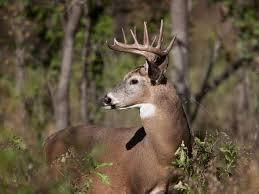

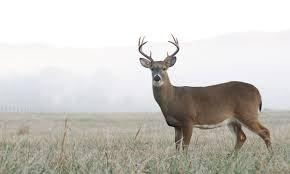

Deer are hoofed mammals known for their graceful bodies and long legs. Most male deer have antlers, which they shed and regrow annually. They are herbivores, generally feeding on a mix of grasses, plants, and leaves. Deer are found in various habitats across the world, including forests, grasslands, and wetlands.


In [ ]:
results = mm_search(query_vector1)

In [ ]:
query_vector2 = [queryToEmbedding('angry lion in a forest').tolist()]

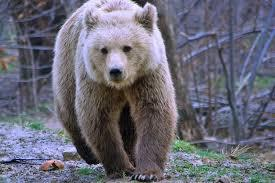

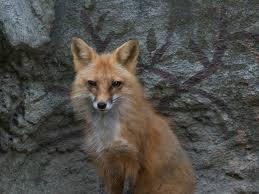

Bears are large mammals with a stocky body, powerful limbs, and a short tail. They have a large brain and are considered among the most intelligent of animals. While many bears are omnivorous, their diets can range from primarily plant-based to entirely carnivorous, depending on the species. They are found in various habitats across the Americas, Europe, and Asia.


In [ ]:
results = mm_search(query_vector2)

RAG with google gemma vision

In [ ]:
!pip install google-generativeai langchain-google-genai streamlit pillow

In [ ]:
# Setup Google API Key, get it here: https://makersuite.google.com/
import os
from getpass import getpass
os.environ["GOOGLE_API_KEY"] = (
    os.environ["GOOGLE_API_KEY"]
    if "GOOGLE_API_KEY" in os.environ
    else getpass("Google API Key: ")
)

Google API Key: ··········


In [ ]:
import google.generativeai as genai
genai.configure(api_key=os.environ["GOOGLE_API_KEY"])

In [ ]:
vision_model = genai.GenerativeModel('gemini-pro-vision')

In [ ]:
# Helper function to get retrieved data ready to send to Gemini
def RAG_Setup(results,retrieved_data_for_RAG):
    for index, row in results[0].iterrows():
        if row[1] == 'image':
            image = Image.open(row[0])
            retrieved_data_for_RAG.append(image)
        elif row[1] == 'text':
            text = read_text_from_file(row[0])
            retrieved_data_for_RAG.append(text)
    return retrieved_data_for_RAG

In [ ]:
prompt = "what can you tell me about the images? What species are they?"

#This will serve as the prompt being sent to Gemini:
query = "You will answer the given prompt using attached content: " + prompt

#Gemini accepts a list of inputs, which include texts and images retrieved from the vector database
#This input list will begin with the query defined above
RAG_list = [query]

#The input list and retrieved results are now passed into the RAG_Setup helper function
#retieved_data_for_RAG will now contain a list including the prompt and retrieved text/image data
retrieved_data_for_RAG = RAG_Setup(results, RAG_list)

In [ ]:
response = vision_model.generate_content(retrieved_data_for_RAG)

print(response.text)

 The first image is of a brown bear, which is a large bear species found in North America, Europe, and Asia. Brown bears are typically brown or black, with a hump on their shoulders and a long, curved claws. They are solitary animals and are omnivorous, with their diet consisting of plants, berries, fish, and meat. Brown bears are apex predators and are considered dangerous to humans.

The second image is of a red fox, which is a small to medium-sized carnivorous mammal belonging to the Canidae family. Red Foxes are found in North America, Europe, and Asia and are known for their reddish-brown fur, white-tipped tail, and pointed ears. They are solitary animals and are opportunistic predators, with their diet consisting of small mammals, birds, insects, and fruits. Red foxes are not considered dangerous to humans.


In [ ]:
table.drop()

True